Maxime Marchand

# Astrophysics and Data Science
## Project 00 : Searching for periodic signals in the unevenly sampled time series

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from tqdm import tqdm

### Part 1 : Polynomial fit
#### Part 1.1 : Data visualization

In [ ]:
# Reading the data
#inFileName = 'data1.csv'
inFileName = 'data2.csv' # Correct one

data = ascii.read(inFileName)

# Plotting the data
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlabel("Time")
ax.set_ylabel("Measurment")
ax.errorbar(data['t'], data['y'], yerr=data['ey'], fmt='ok', label="Data")
ax.legend();

#### Part 1.2 : Modeling the data and model comparison

In this exercise, we consider that the measurments are realizations of an independent Normal (Gaussian) random process, where $ey_i$ is a good estimate of the standard deviation of the distribution. Before modelling the data, we introduce the Bayesian Information Criterion.

##### Bayesian Information Criterion (BIC)

BIC is an estimation tool used in order to differentiate the pertiniency of different models. As increasing the number of parameters of a model will increase the likelihood functions, it may also be counterproductive as the resulting model could overfit the data. The BIC evaluates the pertinency of different models in order to avoid this problem. The BIC is expressed as :

\begin{equation}
BIC = k \ln(n) - 2 \log(\mathcal{L})
\end{equation}

Where $k$ is the number of parameters, $n$ the number of measurments and $\mathcal{L}$ the likelihood function that corresponds to the distribution. In the case of a gaussian distribution, the BIC can be written as :

\begin{equation}
BIC = \chi^2 + k \ln(n)
\end{equation}

> ##### Demonstration
> *Starting from the definition of a Gaussian distribution :*
>
>\begin{equation}
f(\sigma, \mu) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left( -\frac{1}{2} \left(\frac{x - \mu}{\sigma}\right)^2 \right)
\end{equation}
>
>*The corresponding likelihood function for such a distribution is given by :*
>
>\begin{equation}
\mathcal{L} = \frac{1}{\sqrt{\textrm{det}(2\pi\mathbf{\Sigma})}} \exp\left(-\frac{1}{2} (y - f_a)^T \mathbf{W} (y - f_a)\right) = \frac{1}{\sqrt{\textrm{det}(2\pi\mathbf{\Sigma})}} \exp \left(-\frac{1}{2}\chi^2\right)
\end{equation}
>
>*Where the last equality is justified by the fact that, in our case, the weight matrix $\mathbf{W}$ is diagonal. Taking the logarithm leads us to :*
>
>\begin{equation}
\log(\mathcal{L}) = - \frac{1}{2} \log\left(\textrm{det}(2\pi\mathbf{\Sigma})\right) - \frac{1}{2}\chi^2
\quad \Leftrightarrow \quad 
-2 \log(\mathcal{L}) = \log(\textrm{det}(2\pi\mathbf{\Sigma})) + \chi^2
\end{equation}
> *We can identify this result with the second term of the definition of the BIC above, close to a constant. As this constant only depends on the data, and not on the model, one can remove it without influencing the relative BIC factors between different models.*




Given two models $M_0$ and $M_1$, the Bayes Factor can be evaluated as :

\begin{equation}
BF(M_1) = \frac{P(D|M_0)}{P(D|M_1)} \approx \exp\left( \frac{\Delta BIC}{2} \right) = \exp \left( \frac{BIC(M_1) - BIC(M_0)}{2} \right)
\end{equation}

It is clear that a if $\log(BF) < 0$, model $M_1$ will be preferred, and vice versa. Thus, for $N$ different models, the best model will be given by the one having the "less negative" value.

In [ ]:
def get_chi2(y, X, a, Weight):
    return (y - X @ a).T @ Weight @ (y - X @ a)

In [ ]:
def compute_BIC(k, n, chi2):
    return chi2 + k * np.log(n)

In [ ]:
def compute_BF(n, k1, k2, chi21, chi22):
    return np.exp(0.5 * (compute_BIC(k2, n, chi22) - compute_BIC(k1, n, chi21)))

We now implement the model of the fit, which is given by :

\begin{equation}
f_l(t_i, \mathbf{a}) = \sum_{k=0}^{l} a_k \left( \frac{t_i - t_{ref}}{365.25} \right)^k = \mathbf{X} \cdot \mathbf{a} \quad \quad ; \quad \quad t_{ref} = \dfrac{t_{min} + t_{max}}{2}
\end{equation}

Where we have

\begin{equation}
f_l = \begin{bmatrix} f_l(t_0, \mathbf{a}) \\ f_l(t_1, \mathbf{a}) \\ \vdots \\ f_l(t_l, \mathbf{a}) \end{bmatrix} 
\quad ; \quad
\mathbf{X} = \begin{bmatrix} 1 & \frac{t_0-t_{ref}}{365.25} & \left(\frac{t_0-t_{ref}}{365.25}\right)^2 & \cdots & \left(\frac{t_0-t_{ref}}{365.25}\right)^l \\
1 & \frac{t_1-t_{ref}}{365.25} & \left(\frac{t_1-t_{ref}}{365.25}\right)^2 & \cdots & \left(\frac{t_1-t_{ref}}{365.25}\right)^l \\
\vdots & \vdots & \vdots & \vdots & \vdots \\ 1 & \frac{t_n-t_{ref}}{365.25} & \left(\frac{t_n-t_{ref}}{365.25}\right)^2 & \cdots & \left(\frac{t_n-t_{ref}}{365.25}\right)^l \end{bmatrix}
\quad ; \quad
\mathbf{a} = \begin{bmatrix} a_0 \\ a_1 \\ \vdots \\ a_l \end{bmatrix}
\end{equation}

In order to fit this model, we are going to build the basis matrix $\mathbf{X}$, and implement the covariance matrix $\mathbf{\Sigma}$, the weight matrix $\mathbf{W}$ and the covariance matrix $\mathbf{C_a}$ :

\begin{equation}
\mathbf{\Sigma} = 
\begin{bmatrix} 
ey_0^2 & 0      & \cdots & 0       \\
  0    & ey_1^2 & \cdots & 0       \\
  0    & 0      & \ddots & \vdots  \\
  0    & \cdots & \cdots & ey_n^2
\end{bmatrix}
\quad ; \quad
\mathbf{W} = \mathbf{\Sigma^{-1}}
\quad ; \quad \mathbf{C_a} = \big( \mathbf{X}^T \cdot \mathbf{\Sigma}^{-1} \cdot \mathbf{X} \big)^{-1}
\end{equation}

Once it is done, we are able to find the set of parameters $\mathbf{a_{MLE}} = \mathbf{C_a} \cdot  \mathbf{X}^T \cdot \mathbf{W} \cdot \mathbf{y}$,  such that the likelihood is maximized. Our best fit model is thus given by the formula :

\begin{equation}
\mathbf{\hat{y}} = \mathbf{\Pi_X} \cdot \mathbf{y}
\quad\quad ; \quad\quad
\mathbf{\Pi_X} = \big( \mathbf{X}^T \cdot \mathbf{\Sigma}^{-1} \cdot \mathbf{X} \big)^{-1} \cdot \mathbf{X}^T \cdot \mathbf{\Sigma^{-1}}
\end{equation}

In [ ]:
def get_matrix_X(t, n, tref):
    """
    Return the basis matrix X
    
    PARAMETERS
        t    : The time series (np.array)
        n    : Degree of the polynom
        tref : Reference epoch
    """
    lines = []
    for i in range(len(t)):
        lines.append([((t[i] - tref)/365.25)**k for k in np.arange(0, n+1, 1)])
    return np.vstack([_ for _ in lines])

In [ ]:
def fit_Model(data, n, tref):
    X         = get_matrix_X(data['t'], n, tref)               # Basis matrix
    Sigma     = np.diag(data['ey']**2)                         # COVARIANCE matrix
    Weight    = np.linalg.inv(Sigma)                           # Weight matrix
    Ca        = np.linalg.inv(X.T @ Weight @ X)                # Covariance matrix
    aMLE      = Ca @ X.T @ Weight @ data['y']
    aStd      = np.sqrt(np.diag(Ca))
    Ra        = Ca/(aStd[:,np.newaxis]*aStd[np.newaxis,:])     # Correlation matrix of aMLE
    
    yMLE      = X @ aMLE
    SigmayMLE = X @ Ca @ X.T
    yStd      = np.sqrt(np.diag(SigmayMLE))
    
    chi2      = get_chi2(data['y'], X, aMLE, Weight)
    BIC       = compute_BIC(len(aMLE), len(data['t']), chi2)

    return aMLE, aStd, yMLE, yStd, chi2, BIC, X, Sigma, Weight, Ca, Ra

In [ ]:
def fModel(t, a, tref):
    return np.sum([ a[k] * ((t-tref)/365.25)**k for k in range(len(a))], axis=0)

Now that we have the tools to fit the model, we try this for many polynom degrees

In [ ]:
degrees = [0, 1, 2, 3, 4, 5]

tmin = np.min(data['t'])
tmax = np.max(data['t'])

# Uncomment for part 1.4
tref = 0.5 * (tmin + tmax)
#tref = tmin
#tref = tmax
#tref = 2 * tmin - tmax


results = {'n'    : [], 'aMLE' : [], 'aStd' : [],'yMLE'   : [],   'yStd' : [], 
           'chi2' : [], 'BIC'  : [], 'X'    : [], 'Sigma' : None, 'Weight' : None, 'Ca' : [],
           'Ra'   : []}

for n in degrees:
    aMLE, aStd, yMLE, yStd, chi2, BIC, X, Sigma, Weight, Ca, Ra = fit_Model(data, n, tref)
    results['n'].append(n)
    results['aMLE'].append(aMLE)
    results['aStd'].append(aStd)
    results['yMLE'].append(yMLE)
    results['yStd'].append(yStd)
    results['chi2'].append(chi2)
    results['BIC'].append(BIC)
    results['X'].append(X)
    results['Ca'].append(Ca)
    results['Ra'].append(Ra)
    
    if results['Sigma'] is None:
        results['Sigma'] = Sigma
    if results['Weight'] is None:
        results['Weight'] = Weight

# Printing chi2 and BIC values
print("n   chi2    BIC")
[print("{} {:>9.3f} {:.3f}".format(*_)) for _ in zip(results['n'], results['chi2'], results['BIC'])]

# Printing Bayes factor
print("\nBayes Factor (log) :")
numMes = len(data['t'])
print("n  ", *degrees, sep='       ')

for i in range(len(degrees)):
    print(results['n'][i], end='  ')
    k1 = len(results['aMLE'][i])
    chi21 = results['chi2'][i]

    for j in range(len(degrees)):
        k2 = len(results['aMLE'][j])
        chi22 = results['chi2'][j]
        print("{:>8.1f}".format(np.log(compute_BF(numMes, k1, k2, chi21, chi22))), end='')
    
    print()
    

# Plotting matrices
fig, ax = plt.subplots(nrows=1, ncols=3, figsize =(12, 4))
ax[0].set_title("Covariance matrix $\mathbf{\Sigma}$")
ax[0].imshow(Sigma)
ax[1].set_title("Weight matrix $\mathbf{W}$")
ax[1].imshow(Weight)
ax[2].set_title("Covariance matrix $\mathbf{C_a}$")
ax[2].imshow(Ca);
plt.show()

print("\nCorrelation matrices Ra :")
fig, ax = plt.subplots(nrows=1, ncols=len(degrees), figsize=(20, 3))
for i in range(len(degrees)):
    ax[i].set_title("n = {}".format(results['n'][i]))
    ax[i].imshow(results['Ra'][i])
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)

## Look at those beautiful matrices !!!
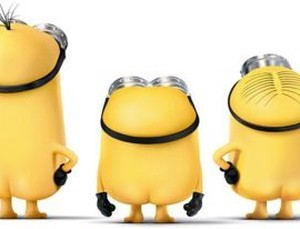

#### Part 1.3 : Data visualization

In [ ]:
t = np.linspace(np.min(data['t']), np.max(data['t']), 100)

fig, ax = plt.subplots(nrows=2, ncols=len(degrees), figsize=(30, 5), dpi=100, gridspec_kw={'height_ratios': [3, 1]})
fig.subplots_adjust(hspace=0, wspace=0.15)

for i in tqdm(range(len(degrees))):
    ax[0, i].set_title("n = {}".format(results['n'][i]))
    ax[0, i].xaxis.set_visible(False)
    ax[0, i].errorbar(data['t'], data['y'], yerr=data['ey'], fmt='ok', label="Data")
    
    # Smooth plot
    ax[0, i].plot(t, fModel(t, results['aMLE'][i], tref), label="Model fit")
    Xs = get_matrix_X(t, degrees[i], tref)
    ys = Xs @ results['aMLE'][i]
    Sigmays=Xs@results['Ca'][i]@Xs.T
    ysStd=np.sqrt(np.diag(Sigmays))

    ax[0, i].fill_between(t, ys-ysStd,ys+ysStd, alpha=0.3, label="Error")
    
    # Residuals plots
    res = data['y'] - results['yMLE'][i]
    ax[1, i].errorbar(data['t'], res, yerr=data['ey'], fmt='.', label="Residual", c='k')
    ax[1, i].axhline(  0, c='gray', alpha=0.5)
    ax[1, i].axhline( 10, c='gray', alpha=0.5)
    ax[1, i].axhline(-10, c='gray', alpha=0.5)
    ax[1, i].set_ylim(-20, 20)
    ax[1, i].set_xlabel("Time")
    

ax[0, 0].yaxis.set_visible(True)
ax[0, 0].set_ylabel("Measurement")
ax[0, -1].legend()
ax[1, 0].yaxis.set_visible(True)
ax[1, 0].set_ylabel("Residuals")
ax[1, -1].legend()
ax[1, -1].yaxis.set_visible(True)

#### Part 1.4 : Impact of reference epoch on data modeling

In order to study the impact of the reference epoch, we do the analysis for $t_{ref} = t_{min}$, $t_{ref} = t_{max}$, and $t_{ref} = 2t_{min} - t_{max}$ \
To avoid code rewriting, simply restart the kernel after having modified the variable tref in part 1.2. \

### Part 2 : Periodogram
#### Part 2.1 : Modeling the data

We now try to add an other periodic signal in our data. The model will be :

\begin{equation}
g_m(t_i|\mathbf{a}) = \sum_{k=0}^{m} a_k \left( \frac{t_i - t_{ref}}{365.25} \right)^k + a_{m+1} \cos \left( 2\pi\nu_j (t_i - t_{ref}) \right) + a_{m+2} \sin \left( 2\pi\nu_j (t_i - t_{ref}) \right)
\end{equation}

This model is simlar as the one before, except the addition of two additionnal terms. To avoid confusion in the code, let denote the basis matrix by $\mathbf{Y}$.


We will probe this model of the following set of frequencies :

\begin{equation}
\nu_j = \frac{1}{P_j} = \frac{1}{\Delta T} \frac{j}{5} \quad ; \quad j = 1, \cdots, N_f = 5000
\end{equation}

In [ ]:
def get_matrix_Y(t, nu, n):
    
    tmin = np.min(t)
    tmax = np.max(t)
    tref = 0.5 * (tmin + tmax)
    
    X    = get_matrix_X(t, n, tref)
    col1 = np.array(np.cos(2 * np.pi * nu * (t - tref))).T
    col2 = np.array(np.sin(2 * np.pi * nu * (t - tref))).T

    return np.c_[X, col1, col2]

In [ ]:
def fit_Model_periodogram(data, n, nu):
    Y         = get_matrix_Y(data['t'], nu, n)   # Basis matrix
    Sigma     = np.diag(data['ey']**2)           # Correlation matrix
    Weight    = np.linalg.inv(Sigma)             # Weight matrix
    Ca        = np.linalg.inv(Y.T @ Weight @ Y)  # Covariance matrix
    aMLE      = Ca @ Y.T @ Weight @ data['y']
    aStd      = np.sqrt(np.diag(Ca))
    yMLE      = Y @ aMLE
    SigmayMLE = Y @ Ca @ Y.T
    yMLEStd   = np.sqrt(np.diag(SigmayMLE))
    
    chi2      = get_chi2(data['y'], Y, aMLE, Weight)
    BIC       = compute_BIC(len(aMLE), len(data['t']), chi2)

    return dict({'aMLE'  : aMLE, 'aStd'  : aStd,  'yMLE'   : yMLE,    
                  'yStd' : yStd, 'chi2'  : chi2,  'BIC'    : BIC,     
                  'Y'    : Y,    'Sigma' : Sigma, 'Weight' : Weight,  
                  'Ca'   : Ca})

In [ ]:
results_model2 = dict()

DeltaT = np.max(data['t']) - np.min(data['t'])
numsample = 5000
frequencies = [j/(5*DeltaT) for j in range(1, numsample+1)]
periods = [1/_ for _ in frequencies]

for i in range(len(degrees)):
    n = degrees[i]
    results_model2[str(n)] = dict({'nu'   : [],   'aMLE'  : [],   'aStd'   : [],   'yMLE'   : [],    
                                   'yStd' : [],   'chi2'  : [],   'BIC'    : [],     
                                   'Y'    : [],   'Sigma' : None, 'Weight'  : None,  
                                   'Ca'   : [],   'per'   : []})
    for j in tqdm(range(len(frequencies)), desc="Fitting n = {} ... ".format(degrees[i])):
        nu = frequencies[j]
        res = fit_Model_periodogram(data, n, nu)
        
        results_model2[str(n)]['nu'].append(nu)        
        results_model2[str(n)]['aMLE'].append(res['aMLE'])
        results_model2[str(n)]['aStd'].append(res['aStd'])
        results_model2[str(n)]['yMLE'].append(res['yMLE'])
        results_model2[str(n)]['yStd'].append(res['yStd'])
        results_model2[str(n)]['chi2'].append(res['chi2'])
        results_model2[str(n)]['BIC'].append(res['BIC'])
print("OK :-)")

#### Part 2.2 : Periodogram as model comparison

We now build the periodogramm using the following formula :

\begin{equation}
    p_j(m, l) = p(\nu_j,\{m, l\}) = \frac{\chi^{2}_{f_l} - \chi^{2}_{g_m}(\nu_{j})}{\chi^{2}_{f_l}}
\end{equation}

##### Point a) Explaining the formula

A quel point c'est probable que ce qu'on observe soit vrai en assumant que l'hypothèse nulle soit vraie (pas compris)

##### Point b) Program that computes the periodogram defined above.

In [ ]:
for i in range(len(degrees)):
    n = degrees[i]
    results_model2[str(n)]['per'] = (results['chi2'][i] - np.array(results_model2[str(n)]['chi2'])/results['chi2'][i]) # Point 2.2.b

##### Point c) Program that computes the periodogram according to the BIC value

\begin{equation}
p_j(m, l) = p(\nu_j, \{m, l\}) = BIC_{f_l} - BIC_{g_m}(\nu_j)
\end{equation}

In [ ]:
for i in range(len(degrees)):
    n = degrees[i]
    results_model2[str(n)]['perBIC'] = np.array(results['BIC'][i] - results_model2[str(n)]['BIC'])

#### Part 2.3 : Data Visualisation
Attention aux limites des axes verticaux

In [ ]:
fig, ax = plt.subplots(nrows=len(degrees), ncols=2, figsize=(20, 10), dpi=300)
fig.subplots_adjust(hspace=0.6, wspace=0.1)

print("{:<4}  {:<6}  {:<6}   {:<6}".format('n', 'freq', 'per', 'periodo'))

for i in range(len(degrees)):
    n = degrees[i]
    
    # Finding maximum value to display on graph
    Z = list(zip(periods, results_model2[str(n)]['perBIC']))
    Z.sort(key=lambda x: x[1])
    maxPer = Z[-1][0] # x coordinate of the maximum value (period)

    print("{:<4} {:>6.3f}  {:>6.3f}    {:>6.3f}".format(n, 1/Z[-1][0], Z[-1][0], Z[-1][1]))

    # Graphs on the left (Frequency)
    ax[i, 0].set_xlabel("Frequency")
    ax[i, 0].plot(frequencies, results_model2[str(n)]['perBIC'], linewidth=0.5)
    # Graphs on the right (Periods)
    ax[i, 1].set_xlabel("Period (log)")
    ax[i, 1].set_xscale('log')
    
    ax[i, 1].plot(periods, results_model2[str(n)]['perBIC'], linewidth=0.5, label='Periodogram')
    ax[i, 1].axvline(maxPer, c='r', linewidth=1, label='max')
    ax[i, 1].axhline(2*np.log(150), c='g', linewidth=1)

ax[0, 1].legend(bbox_to_anchor=(1.05, 1.5)); 